# Gas turbine combastion chamber model using Cantera constant volume reactor net

Sources: </br>
* Cantera documentation and code examples
<ol>
https://www.cantera.org/docs/sphinx/html/reactors.html
https://www.cantera.org/docs/sphinx/html/cython/examples/reactors_combustor.html#py-example-combustor-py
https://www.cantera.org/docs/sphinx/html/cython/examples/reactors_pfr.html#py-example-pfr-py
</ol>
* CERFACS tutorials
<ol>
http://www.cerfacs.fr/cantera/docs/tutorials/CANTERA_HandsOn.pdf
</ol>
* "Prediction of emissions from combustion systems using 0D and 1D reacting flow models", B.Rosati
<ol>
https://repository.tudelft.nl/islandora/object/uuid:e4123ab3-0d3d-48cc-8b71-ada6badc83e7
</ol>
* "Water Injection in Gas Turbines - Kinetic Modeling with Cantera", S. M. Reiz
<ol>
https://www5.in.tum.de/pub/Reiz2014_BThesis.pdf
</ol>
* "Chemical Reactor Modeling of Oxy - Fuel Combustion Chamber for Semiclosed Combined Cycle", V. P. Timón, G. Corchero, J. L. Montañés
<ol>
https://pubs.acs.org/doi/10.1021/acs.energyfuels.7b01311
</ol>

Importing neccesery libraries

In [1]:
import math
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

Model inputs

In [2]:
#thermodynamic parameters

T0_air = 700.0 #air temperature [K]
T0_ch4 = 300.0 #methane temperature [K]
p0 = 2500000.0 #inlet preassure[Pa]
eqv = 0.6 #equivalence ratio
ftar = 1 / 17.2 #fuel to air ratio
X = 0.2 #mixer/DZ air injection ratio
air_mf1 = X * 100.0 #air mass flow [kg/s]
air_mf2 = (1 - X) * 100.0 #air mass flow to DZ[kg/s]
ch4_mf = ftar*eqv*air_mf1

#internal parameters

Kv = 50.0 #valve coefficient
N = 2000 #number of steps

#geometrical parameters

Dc = 0.3 #combustor diameter [m]
D = 0.1 #mixing tube diameter [m]
Dh_SZ = 0.01 #dilution holes diameter SZ [m]
Dh_DZ = 0.01 #dilution holes diameter DZ [m]
mixer_length = 0.1 #[m]
PZ_length = 0.1 #[m]
SZ_length = 0.4 #[m]
DZ_length = 0.4 #[m]
Lc = mixer_length + PZ_length + SZ_length + DZ_length

mixer_vol = mixer_length * D**2 * math.pi / 4
PZ_vol = PZ_length* Dc**2 * math.pi / 4
SZ_vol = SZ_length* Dc**2 * math.pi / 4 / N
DZ_vol = DZ_length* Dc**2 * math.pi / 4 / N

#igniter
fwhm = 0.2
amplitude = 0.1
t0 = 0.2
igniter_mdot = lambda t: amplitude * math.exp(-(t-t0)**2 * 4 * math.log(2) / fwhm**2)

Setting up gas reservoirs and parameters

In [3]:
air = ct.Solution('air.xml')
air.TP = T0_air, p0, 
air_res = ct.Reservoir(air)

air.TP = 300.0, ct.one_atm
env = ct.Reservoir(air)

ch4 = ct.Solution('gri30.xml')
ch4.TPX = T0_ch4, p0, 'CH4:1.0'
ch4_res = ct.Reservoir(ch4)

upstream_gas = ct.Solution('gri30.xml')
upstream_gas.TPX = 300.0, p0, 'N2:1.0'
upstream = ct.Reservoir(upstream_gas)

downstream_gas = ct.Solution('gri30.xml')
downstream_gas.TPX = 300.0, p0, 'N2:1.0'
downstream = ct.Reservoir(downstream_gas)

h = ct.Solution('gri30.xml')
h.TPX = 300.0, p0, 'H:1.0'
igniter = ct.Reservoir(h)

Setting up reactors

In [4]:
mixer = ct.IdealGasReactor(downstream_gas,energy = 'on')
mixer.volume = mixer_vol

PZ = ct.IdealGasReactor(downstream_gas, energy = 'on')
PZ.volume = PZ_vol

SZ = ct.IdealGasReactor(downstream_gas, energy = 'on')
SZ.volume = SZ_vol

DZ = ct.IdealGasReactor(downstream_gas, energy = 'on')
DZ.volume = DZ_vol

Setting up flow devices and walls

In [5]:
air_mfc1 = ct.MassFlowController(air_res, mixer, mdot = air_mf1)
ch4_mfc = ct.MassFlowController(ch4_res, mixer, mdot = ch4_mf)
SZ_mfc = ct.MassFlowController(upstream, SZ, mdot = air_mf1 + ch4_mf)
DZ_mfc = ct.MassFlowController(upstream, DZ, mdot = air_mf1 + ch4_mf)
igniter_mfc = ct.MassFlowController(igniter, PZ, mdot = igniter_mdot)

holes_number_SZ = math.floor(SZ_length / 0.25)
holes_number_DZ = math.floor(DZ_length / 0.1)
norph_SZ = Dh_SZ / (SZ_length / N) #number of reactors per hole SZ
norph_DZ = Dh_DZ / (DZ_length / N) #number of reactors per hole DZ
dilution_air_mf = air_mf2 / (holes_number_SZ * norph_SZ + holes_number_DZ * norph_DZ)

SZ_air_mfc = ct.MassFlowController(air_res, SZ, mdot = 0.0)
DZ_air_mfc = ct.MassFlowController(air_res, DZ, mdot = 0.0)

mixer_v = ct.Valve(mixer, PZ, K = Kv)
PZ_v = ct.Valve(PZ, upstream, K = Kv)
SZ_v = ct.Valve(SZ, downstream, K = Kv)
DZ_v = ct.Valve(DZ,downstream, K = Kv)

PZ_wall = ct.Wall(PZ, env, A = PZ_length*D*math.pi, U = 20000.0)
SZ_wall = ct.Wall(SZ, env, A = SZ_length/N*D*math.pi, U = 20000.0)
DZ_wall = ct.Wall(DZ, env, A = DZ_length/N*D*math.pi, U = 20000.0)

Iteration of CSTR net

In [12]:
sim = ct.ReactorNet([mixer, PZ])

sim.advance_to_steady_state()

upstream_gas.TDY = PZ.thermo.TDY
upstream.syncState()

#print(mixer.thermo.report())
#print(PZ.thermo.report())
#print(upstream.thermo.report())

Iteration of first PFR net

In [7]:
dz = SZ_length / N
mass_flow_rate2 = air_mf1 + ch4_mf

sim2 = ct.ReactorNet([SZ])

z2 = (np.arange(N) + 1) * dz + (mixer_length + PZ_length)
i = 0
a = 0
t_SZ = np.zeros_like(z2)  # residence time in each reactor
u2 = np.zeros_like(z2)
t2 = np.zeros_like(z2)
states2 = ct.SolutionArray(SZ.thermo)
# iterate through the PFR cells
for n in range(N):
    if z2[n] >= ((2 * i + 1) * 0.125 - Dh_SZ / 2) and z2[n] <= ((2 * i + 1) * 0.125 + Dh_SZ / 2):
        SZ_air_mfc.set_mass_flow_rate(dilution_air_mf)
        mass_flow_rate2 += dilution_air_mf
        sim2.reinitialize()
        sim2.advance_to_steady_state()
        u2[n] = mass_flow_rate2 / (Dc**2 * math.pi / 4) / SZ.thermo.density
        t_SZ[n] = SZ.mass / mass_flow_rate2  # residence time in this reactor
        t2[n] = np.sum(t_SZ)
        states2.append(SZ.thermo.state)
        upstream_gas.TDY = SZ.thermo.TDY
        upstream.syncState()
        a += 1
        if a == norph_SZ:
            i +=1
    else:
        SZ_air_mfc.set_mass_flow_rate(0.0)
        # integrate the reactor forward in time until steady state is reached
        sim2.reinitialize()
        sim2.advance_to_steady_state()
        # compute velocity and transform into time
        u2[n] = mass_flow_rate2 / (Dc**2 * math.pi / 4) / SZ.thermo.density
        t_SZ[n] = SZ.mass / mass_flow_rate2  # residence time in this reactor
        t2[n] = np.sum(t_SZ)
        # write output data
        states2.append(SZ.thermo.state)
        # Set the state of the reservoir to match that of the previous reactor
        upstream_gas.TDY = SZ.thermo.TDY
        upstream.syncState()  

Plotting secondary zone calculation results

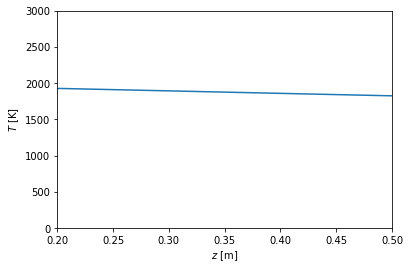

In [8]:
plt.figure()
plt.plot(z2, states2.T)
plt.xlabel('$z$ [m]')
plt.ylabel('$T$ [K]')
plt.axis([mixer_length + PZ_length, Lc - DZ_length, 0, 3000])
plt.show()
#plt.savefig('PZ_T_z.png')

Iteration of second PFR net

In [14]:
dz = DZ_length / N

sim3 = ct.ReactorNet([DZ])

z3 = (np.arange(N) + 1) * dz + (mixer_length + PZ_length + SZ_length)
i = 0
a = 0
t_DZ = np.zeros_like(z3)  # residence time in each reactor
u3 = np.zeros_like(z3)
t3 = np.zeros_like(z3)
states3 = ct.SolutionArray(DZ.thermo)

for n in range(N):
    if z3[n] >= ((2 * i + 1) * 0.125 - Dh_SZ / 2) and z3[n] <= ((2 * i + 1) * 0.125 + Dh_SZ / 2):
        DZ_air_mfc.set_mass_flow_rate(dilution_air_mf)
        mass_flow_rate2 += dilution_air_mf
        sim3.reinitialize()
        sim3.advance_to_steady_state()
        u3[n] = mass_flow_rate2 / (Dc**2 * math.pi / 4) / DZ.thermo.density
        t_DZ[n] = DZ.mass / mass_flow_rate2  # residence time in this reactor
        t3[n] = np.sum(t_SZ)
        states2.append(DZ.thermo.state)
        upstream_gas.TDY = DZ.thermo.TDY
        upstream.syncState()
        a += 1
        if a == norph_SZ:
            i +=1
    else:
        DZ_air_mfc.set_mass_flow_rate(0.0)
        # integrate the reactor forward in time until steady state is reached
        sim3.reinitialize()
        sim3.advance_to_steady_state()
        # compute velocity and transform into time
        u3[n] = mass_flow_rate2 / (Dc**2 * math.pi / 4) / DZ.thermo.density
        t_DZ[n] = DZ.mass / mass_flow_rate2  # residence time in this reactor
        t3[n] = np.sum(t_DZ)
        # write output data
        states3.append(DZ.thermo.state)
        # Set the state of the reservoir to match that of the previous reactor
        upstream_gas.TDY = DZ.thermo.TDY
        upstream.syncState()  
downstream_gas.TDY = DZ.thermo.TDY
downstream.syncState()
#print(downstream.thermo.report())

Plotting dilution zone calculation results

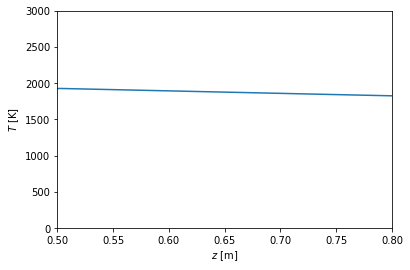

In [16]:
plt.figure()
plt.plot(z3, states3.T)
plt.xlabel('$z$ [m]')
plt.ylabel('$T$ [K]')
plt.axis([Lc - DZ_length, Lc, 0, 3000])
plt.show()
#plt.savefig('DZ_T_z.png')